## Random Forest

Loading data...
Dataset shape: (117349, 24)

Target distribution:
y_active
0    61982
1    55367
Name: count, dtype: int64

Features used: ['dt', 'isClick', 'isComment', 'isIntoPersonalHomepage', 'isShare', 'isViewComment', 'isLike', 'province', 'publishTime', 'type', 'creatorType', 'creator_level', 'PushlishMlogCnt', 'age_gender_missing', 'pop_index_pca_lag1', 'mlogViewTime_log', 'impressPosition_log', 'followCnt_log']

Categorical columns to encode: ['province', 'type', 'creatorType']

Features after encoding: 60
Encoded columns: ['dt', 'isClick', 'isComment', 'isIntoPersonalHomepage', 'isShare', 'isViewComment', 'isLike', 'publishTime', 'creator_level', 'PushlishMlogCnt', 'age_gender_missing', 'pop_index_pca_lag1', 'mlogViewTime_log', 'impressPosition_log', 'followCnt_log', 'province_ao men', 'province_bei jing', 'province_fu jian', 'province_gan su', 'province_guang dong', 'province_guang xi', 'province_gui zhou', 'province_hai nan', 'province_hai wai', 'province_he bei', 'province

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s



Making predictions...


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished



MODEL EVALUATION RESULTS

Accuracy: 0.6413
ROC-AUC Score: 0.6932

Classification Report:
              precision    recall  f1-score   support

    Inactive       0.64      0.75      0.69     12397
      Active       0.65      0.52      0.58     11073

    accuracy                           0.64     23470
   macro avg       0.64      0.63      0.63     23470
weighted avg       0.64      0.64      0.64     23470


Confusion Matrix:
[[9299 3098]
 [5321 5752]]

Confusion matrix saved as 'confusion_matrix.png'


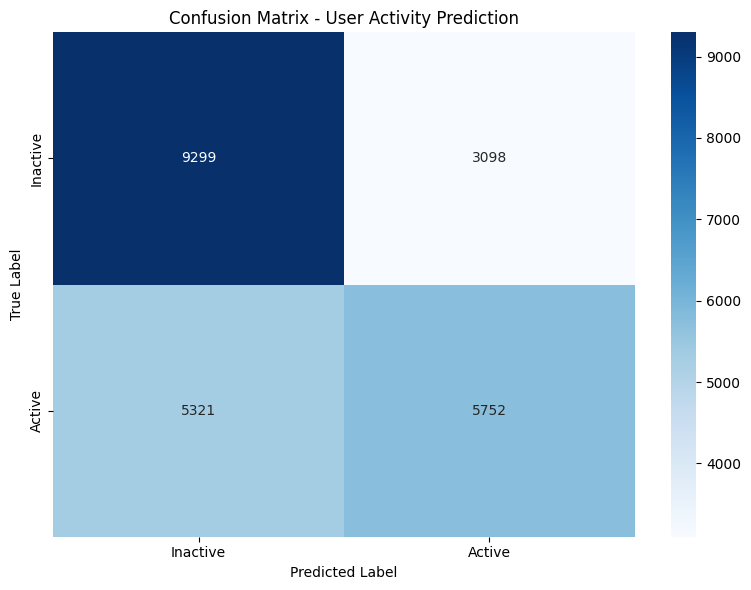


Top 20 Most Important Features:
                feature  importance
          followCnt_log    0.283008
     age_gender_missing    0.183343
province_hei long jiang    0.075318
     province_xin jiang    0.059216
                     dt    0.054270
    impressPosition_log    0.034549
    province_guang dong    0.031602
                 type_2    0.030838
     pop_index_pca_lag1    0.025558
            publishTime    0.024975
     province_shan dong    0.024402
       mlogViewTime_log    0.023657
          creator_level    0.017580
        province_he bei    0.013362
        PushlishMlogCnt    0.013107
                isShare    0.010609
      province_jiang xi    0.007991
        province_hu nan    0.007589
       province_fu jian    0.006117
          creatorType_4    0.005985

Feature importance plot saved as 'feature_importance.png'


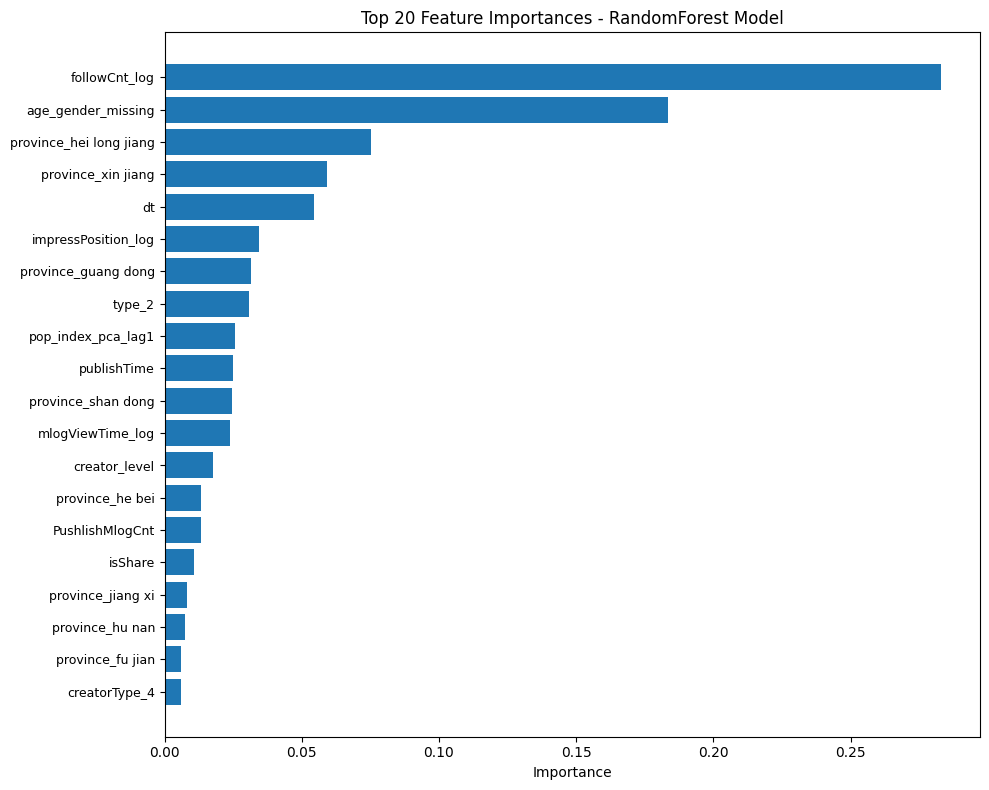

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
print("Loading data...")
df = pd.read_csv("../data/cleaned_data.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:\n{df['y_active'].value_counts()}")

# Define target
target = 'y_active'
y = df[target]

# Select features - avoid high cardinality columns that cause memory issues
# Skip userId, mlogId, creatorId, contentId, talkId as they have too many unique values
exclude_cols = [target, 'userId', 'mlogId', 'creatorId', 'contentId', 'talkId']
X = df.drop(columns=exclude_cols)

print(f"\nFeatures used: {list(X.columns)}")

# Convert day column to datetime and extract numeric features
if 'day' in X.columns:
    X['day'] = pd.to_datetime(X['day'])
    X['day_of_month'] = X['day'].dt.day
    X['day_of_week'] = X['day'].dt.dayofweek
    X['month'] = X['day'].dt.month
    X = X.drop(columns=['day'])
    print("Converted day to numeric features (day_of_month, day_of_week, month)")

# Handle categorical columns with manageable cardinality
categorical_cols = ['province', 'type', 'creatorType']
categorical_cols = [col for col in categorical_cols if col in X.columns]
print(f"\nCategorical columns to encode: {categorical_cols}")

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True, dtype=int)

print(f"\nFeatures after encoding: {X_encoded.shape[1]}")
print(f"Encoded columns: {list(X_encoded.columns)}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Train RandomForest with memory-efficient settings
print("\nTraining RandomForest model...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',  # More memory efficient
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    verbose=1
)

rf_model.fit(X_train, y_train)

# Make predictions
print("\nMaking predictions...")
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("\n" + "="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Inactive', 'Active']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Inactive', 'Active'],
            yticklabels=['Inactive', 'Active'])
plt.title('Confusion Matrix - User Activity Prediction')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
print("\nConfusion matrix saved as 'confusion_matrix.png'")
plt.show()

# Feature importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance_df.head(20).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'], fontsize=9)
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - RandomForest Model')
plt.gca().invert_yaxis()
plt.tight_layout()
print("\nFeature importance plot saved as 'feature_importance.png'")
plt.show()
